In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%matplotlib inline

In [75]:
if torch.cuda.is_available():
  device = torch.device("cuda:0") 
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

CPU


In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Classes & Setup**

In [77]:
class FoodDataset(Dataset):
  
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
    image = Image.open(img_path)
    image.thumbnail((256,256))
    y_label = torch.tensor(int(self.annotations.iloc[index,2]))

    if(self.transform):
      image = self.transform(image)

    return (image, y_label)

In [78]:
# UNUSED
class Network(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
    self.fc1 = nn.Linear(in_features=128 * 24 * 24, out_features=2056 )
    self.fc2 = nn.Linear(in_features=2056, out_features=512 )
    self.out = nn.Linear(in_features=512, out_features=61)

  def forward(self, t):
    #conv
    t = F.relu(self.conv1(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)
    t = F.relu(self.conv2(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)
    t = F.relu(self.conv3(t))
    t = F.max_pool2d(t, kernel_size=2, stride=2)
    #dense
    t = F.relu(self.fc1(t.reshape(-1, 128 * 24 * 24)))
    t = F.relu(self.fc2(t))
    t = self.out(t)
    return t  

In [79]:
#UTIL FUNCTIONS
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
      images, labels = batch
      preds = model(images)

      all_preds = torch.cat((all_preds, preds), dim=0)
  return all_preds

## **Dataset explore**

In [80]:
dataset = FoodDataset(csv_file='/content/drive/My Drive/Practice/FOODC/train_final.csv', 
                      root_dir='/content/drive/My Drive/Practice/FOODC/train_images/',
                      transform = transforms.Compose([
                        transforms.Resize(255),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
                      ]))

In [81]:
# SPLIT
train_set, test_set = torch.utils.data.random_split(dataset, [11305, 2826])

In [82]:
temp_img, temp_label = dataset[0]
print(temp_img.shape)

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


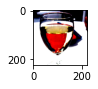

In [83]:
plt.figure(figsize=(1,1))
plt.imshow(temp_img.permute(1,2,0))

## **Train (ON GPU)**

In [84]:
BATCH_SIZE = 100
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [ ]:
# CUSTOM MODEL
# network = Network().to(device)

# TORCHVISION RESNET
network = torchvision.models.resnet18().to(torch.device("cuda:0"))
network.fc = nn.Linear(network.fc.in_features, 61).cuda()
network.train = True

print("Model on GPU: ",next(network.parameters()).is_cuda)

In [92]:
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

Model on GPU:  True


In [ ]:
# TRAIN LOOP
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    total_correct = 0
    batch_num = 0

    for batch in train_loader:
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()

        preds = network(images)
        loss = F.cross_entropy(preds, labels) #CALC LOSS

        optimizer.zero_grad()                 #SET GRADS TO 0
        loss.backward()                       #CALC GRADIENTS
        optimizer.step()                      #UPDATE WEIGHTS

        batch_correct = get_num_correct(preds, labels)
        total_correct += batch_correct
        total_loss += loss.item()

        print("-- BATCH: ",batch_num,"   BATCH ACCURACY: ",(batch_correct/BATCH_SIZE)*100)
        batch_num += 1

    accuracy = total_correct/len(train_set) * 100
    print("EPOCH: ",epoch,"   ACCURACY: ",accuracy ,"   LOSS: ",total_loss)

    # SAVE MODEL -
    checkpoint = {
        'epoch': epoch,
        'total_loss': total_loss,
        'total_correct':total_correct,
        'accuracy': accuracy,
        'model_state_dict': network.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict()
    } 
    checkpoint_path = '/content/drive/My Drive/Practice/FOODC/checkpoints/' + str(epoch) + '.pt' 
    torch.save(checkpoint, checkpoint_path)
    # SAVE MODEL -

## **Resume training**

In [64]:
# def load_checkpoint(model, optimizer, filename):
#     # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
#     if os.path.isfile(filename):
#         print("=> loading checkpoint '{}'".format(filename))
#         checkpoint = torch.load(filename)

#         epoch = checkpoint['epoch']
#         total_loss = checkpoint['total_loss']
#         total_correct = checkpoint['total_correct']
#         accuracy = checkpoint['accuracy'] 
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
#         print("=> loaded checkpoint '{}'".format(filename))
#     else:
#         print("=> no checkpoint found at '{}'".format(filename))

#     return epoch, total_loss, total_correct, accuracy, model, optimizer

## **Testing (ON CPU)**

In [44]:
checkpoint = torch.load('/content/drive/My Drive/Practice/FOODC/checkpoints/14.pt',map_location=torch.device('cpu'))

In [65]:
# TORCHVISION RESNET (TEST ON CPU)
network = torchvision.models.resnet18().to(torch.device('cpu'))
network.fc = nn.Linear(network.fc.in_features, 61)

network.load_state_dict(checkpoint['model_state_dict'])
network.train = False

In [ ]:
# GET PREDICTIONS
test_loader = DataLoader(test_set, 100)
test_preds = []
test_labels = []

with torch.no_grad():
  for test_batch in test_loader:
    print("BATCH")
    images, labels = test_batch
    preds = network(images)
    _, outputs =torch.max(preds.data,1)
    pr = preds.detach().cpu().numpy()
    for p in pr:
      test_preds.append(p.argmax())
    lb = labels.detach().cpu().numpy()
    for l in lb:
      test_labels.append(l)

In [ ]:
# GET ACCURACY
print(len(test_preds))
print(len(test_labels))

total_correct_test = 0 
for i in range(len(test_labels)):
  if test_labels[i] == test_preds[i]:
    total_correct_test += 1

In [73]:
print("ACCURACY: ",total_correct_test/len(test_labels))

ACCURACY:  0.87
